In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

C:\Users\malce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Building The Network

In [2]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.dropout = nn.Dropout(0.2)
    self.lin1 = nn.Linear(200,64)
    self.lin2 = nn.Linear(64,32)
    self.lin3 = nn.Linear(32,4)

  def forward(self, x):   
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.dropout(x) 
    x = F.sigmoid(self.lin3(x))
    return x

In [3]:
def train(net, dataset, optimizer):
  net.train()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = Variable(target).cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print( "train loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

In [4]:
def test(net, dataset):
  net.eval()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = target.cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
  print("test loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

Loading the data

In [5]:
input = pd.read_table("../data/training/train_data_RNA_200.txt", sep = " ", header=0)
labels = pd.read_csv("../data/pre_processed/RNA_annotations.csv")
codes, uniques = labels["Sub_trajectory_name"].factorize()

In [6]:
class Custom_Dataset(Dataset):
    def __init__(self, input, labels):
        dist_labels = torch.Tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
        self.X = [torch.Tensor(row.tolist()) for indx, row in input.iterrows()]
        self.y = [dist_labels[label] for label in labels]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [7]:
data = Custom_Dataset(input, codes)

train_dataset, test_dataset = random_split(data, [0.7, 0.3])

data_loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=64, shuffle=True)

Training

In [8]:
net = Network()
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,30,70], gamma=0.1)

train_loss = []
test_loss = []

for epoch in range(100):
  print("epoch:", epoch+1)
  tr_loss = train(net, data_loader_train, optimizer)
  te_loss = test(net, data_loader_test)
  train_loss.append(tr_loss)
  test_loss.append(te_loss)
  scheduler.step()

np.savez('Learning_Curves.npz', train_loss=train_loss, test_loss=test_loss)
torch.save(net, 'saved_net.py')

epoch: 1
train loss: 0.024434507894382285
test loss: 0.006194626672597798
epoch: 2
train loss: 0.00610825022907626
test loss: 0.005790517121414795
epoch: 3
train loss: 0.004858709052443566
test loss: 0.004972636045625366
epoch: 4
train loss: 0.0043685729005761955
test loss: 0.0050762039845734
epoch: 5
train loss: 0.004082086056532573
test loss: 0.005068963502900428
epoch: 6
train loss: 0.0032010941252216814
test loss: 0.004728644992947669
epoch: 7
train loss: 0.0031107690404108654
test loss: 0.00474222664516243
epoch: 8
train loss: 0.0030283892642605278
test loss: 0.0045944110669163245
epoch: 9
train loss: 0.002981163873220761
test loss: 0.004547217926306315
epoch: 10
train loss: 0.00291780347335515
test loss: 0.004574060010148921
epoch: 11
train loss: 0.002756951323380919
test loss: 0.0044871364332020915
epoch: 12
train loss: 0.002728060820751478
test loss: 0.004495159056482647
epoch: 13
train loss: 0.002719125830811087
test loss: 0.004556577215744203
epoch: 14
train loss: 0.002609734

Evaluation

0.9897068511198946


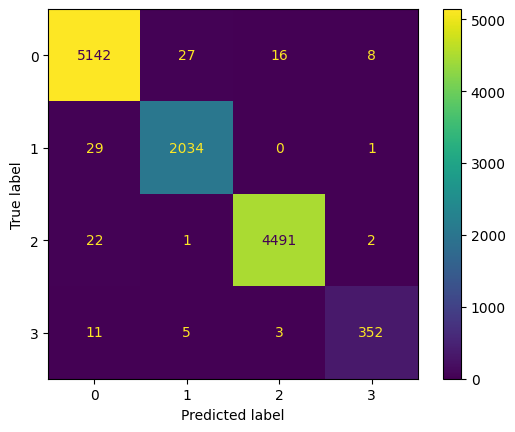

In [9]:
net.cpu()

X = [i for i,j in test_dataset]
pred = [net(x) for x in X]
y_true = [np.argmax(j) for i,j in test_dataset]
y_pred = [np.argmax(i.detach().numpy()) for i in pred]

acc = accuracy_score(y_true, y_pred)

print(acc)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig("conf_mat_RNA_200.png")
plt.show()

Interpretability

In [29]:
net = torch.load("saved_net.py").cpu()
ig = IntegratedGradients(net)
net.eval()
res = np.zeros((4, 200))

for input, target in test_dataset:
    input = input.unsqueeze(0)
    target = torch.argmax(target).unsqueeze(0)
    attributions, delta = ig.attribute(input, target = target, return_convergence_delta=True)
    res[target] += np.array(attributions[0])


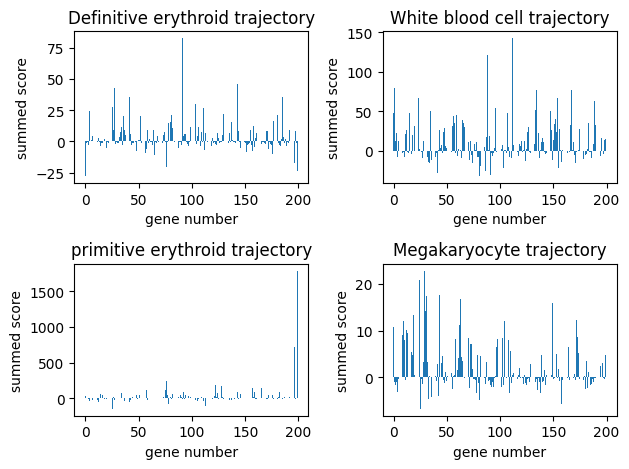

<Figure size 640x480 with 0 Axes>

In [32]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(uniques[i])
    plt.xlabel("gene number")
    plt.ylabel("summed score")
    plt.bar(np.arange(200), res[i])

plt.tight_layout()
plt.show()
plt.savefig("attributions.png")

In [33]:
top_10 = np.zeros((4, 10))

for i in range(4):
    ind = np.argpartition(res[i], -10)[-10:]
    top_10[i] = ind

top_10 = top_10.astype('int32')

In [34]:
genes = pd.read_csv("../DESeq/genes_by_sig_unique.csv")
gene_annotations = pd.read_csv("../data/unprocessed/gene_annotate.csv")

important_genes = pd.DataFrame({"gene_id": [],
                               "gene_name": [],
                               "class" : [],
                               "score" : []})

In [35]:
for i in range(4):
    for j in range(10):
        gene_id = genes.loc[top_10[i,j], "gene"]
        gene_name = gene_annotations.loc[gene_annotations["gene_id"] == gene_id, "gene_short_name"].item()
        clas = uniques[i]
        score = res[i, top_10[i,j]]
        important_genes.loc[len(important_genes.index)] = [gene_id, gene_name, clas, score]
        

In [25]:
important_genes

,gene_id,gene_name,class,score
0,ENSMUSG00000021699.17,Pde4d,Definitive erythroid trajectory,24.221433
1,ENSMUSG00000031543.18,Ank1,Definitive erythroid trajectory,25.625914
2,ENSMUSG00000052305.6,Hbb-bs,Definitive erythroid trajectory,27.126740
3,ENSMUSG00000022377.16,Asap1,Definitive erythroid trajectory,35.405389
4,ENSMUSG00000064339.1,mt-Rnr2,Definitive erythroid trajectory,27.393886
5,ENSMUSG00000000861.15,Bcl11a,Definitive erythroid trajectory,82.563918
6,ENSMUSG00000035472.13,Slc25a21,Definitive erythroid trajectory,45.872109
7,ENSMUSG00000097039.8,Pvt1,Definitive erythroid trajectory,30.291361
8,ENSMUSG00000027784.10,Ppm1l,Definitive erythroid trajectory,42.783555
9,ENSMUSG00000051910.13,Sox6,Definitive erythroid trajectory,35.354896


In [36]:
important_genes.to_csv("important_genes_new.csv")